In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import pandas as pd
import wfdb
import numpy as np
import os

base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "ptbxl_database.csv")  

df = pd.read_csv(metadata_path)

ecg_segments = []

threshold = 5

for idx, row in df.iterrows():
    scp_codes = eval(row["scp_codes"])  

    if "NORM" not in scp_codes or abs(scp_codes["NORM"] - 100) > threshold:
        continue
    hr_path = os.path.join(base_path, row["filename_hr"])  

    record = wfdb.rdrecord(hr_path)

    ecg_signal = record.p_signal[:, 0]

    segment_size = 2000
    num_segments = len(ecg_signal) // segment_size  

    for i in range(num_segments):
        segment = ecg_signal[i * segment_size : (i + 1) * segment_size]
        ecg_segments.append(segment)

    if len(ecg_segments) >= 1000:
        break

ecg_segments = np.array(ecg_segments)
ecg_segments = ecg_segments * 1000

lr_ecg_segments = []
for ecg_segment in ecg_segments:
    lr_ecg_segment = []
    for i in range(len(ecg_segment)):
        if (i % 5 == 0):
            lr_ecg_segment.append(ecg_segment[i])
        elif (i % 5 == 2):
            lr_ecg_segment.append((ecg_segment[i] + ecg_segment[i + 1])/2)
    lr_ecg_segments.append(lr_ecg_segment)

lr_ecg_segments = np.array(lr_ecg_segments)

np.save(os.path.join(base_path, "lr_ecg_segments.npy"), lr_ecg_segments)

print(f"Extracted {len(lr_ecg_segments)} ECG segments of 800 samples each.")


Extracted 1000 ECG segments of 800 samples each.


In [3]:
lr_ecg_segments

array([[-115. , -115. , -115. , ...,  -43. ,    0. ,  -39. ],
       [ -50. ,  -55.5,    0. , ...,   46. ,  160. ,  129. ],
       [ -35. ,  -35. ,  -35. , ...,  -24.5,    0. ,  -32. ],
       ...,
       [ -70. ,  -65. ,  -60. , ..., -169.5, -170. , -143.5],
       [ -50. ,  -50. ,  -50. , ...,  -59.5,  -60. ,  -60. ],
       [ -60. ,  -60. ,  -60. , ...,  -65.5,  -65. ,  -64.5]])

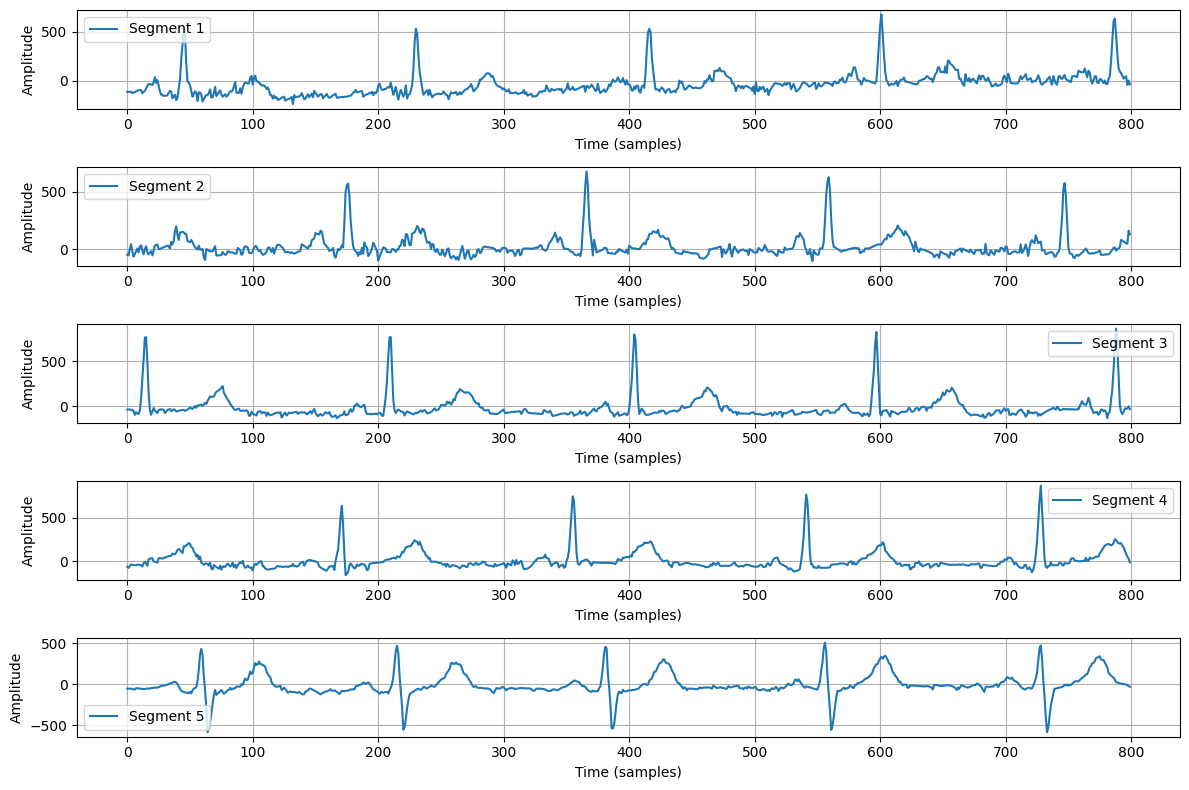

In [4]:
import matplotlib.pyplot as plt

num_segments = min(5, len(lr_ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(lr_ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

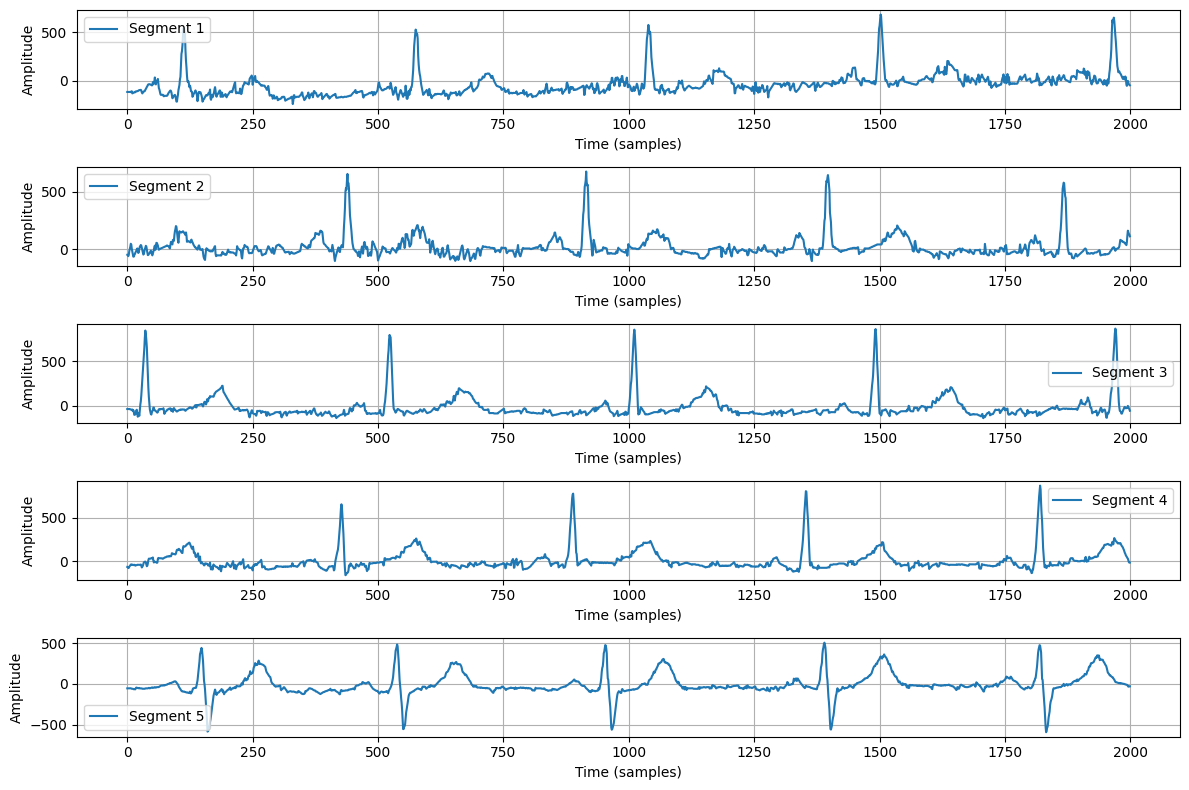

In [5]:
import matplotlib.pyplot as plt

num_segments = min(5, len(ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

In [6]:
base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "augmented_ecg_data.csv")  
vfib_df = pd.read_csv(metadata_path)
vfib_segments = vfib_df.to_numpy()

def replace_outliers(signal, threshold=1000):
    for i in range(len(signal)):
        if abs(signal[i]) > threshold:
            prev_value = signal[i - 1] if i > 0 else 0 
            next_value = signal[i + 1] if i < len(signal) - 1 else 0  
            signal[i] = (prev_value + next_value) / 2
    return signal

for vfib_segment in vfib_segments:
    replace_outliers(vfib_segment)

print(vfib_segments)
print(len(vfib_segments))

[[-120.72434608 -211.70142784 -268.2964205  ...  198.47019947
   144.28482312   12.5211549 ]
 [ -40.24144869 -139.17962828 -142.89251696 ...  362.93909082
   179.87199303   12.07521375]
 [ -80.48289738 -153.13560871 -231.75195941 ...  175.13483458
    87.34533057   12.50718704]
 ...
 [-160.96579477 -287.19425422 -363.23176856 ...  123.20060587
    23.6556075    16.68191397]
 [   0.            8.93268725   43.26224568 ...  190.42450771
    81.78078097  -29.08804546]
 [-181.08651911 -307.87950195 -458.37796498 ...   99.13712183
    92.36334115   -8.70452598]]
558


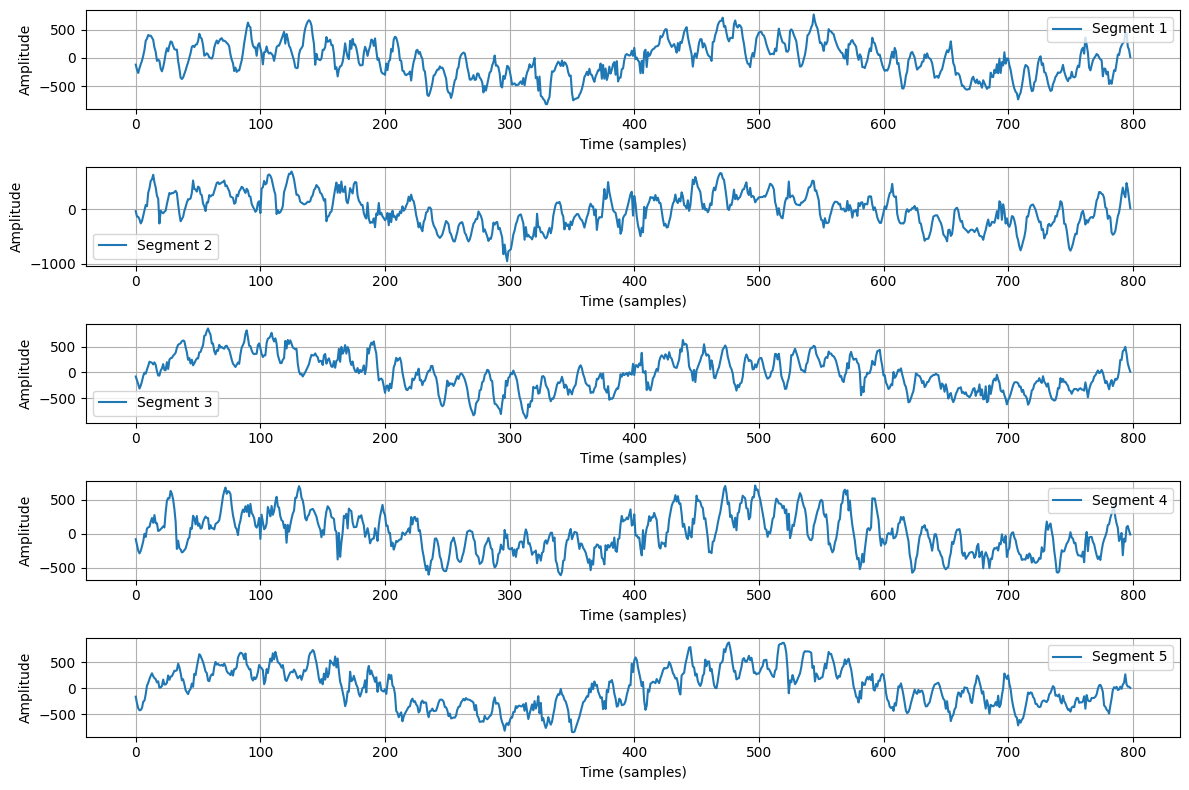

In [7]:
num_segments = min(5, len(vfib_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(vfib_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

In [9]:
import random
random.seed(42)
nsr_segments = np.array(random.sample(list(lr_ecg_segments), 558))
nsr_segments

array([[-160. , -160. , -160. , ...,  -45.5,  -40. ,  -45.5],
       [  25. ,   24.5,   25. , ...,  -70. ,  -70. ,  -75. ],
       [   5. ,    4.5,    5. , ...,  102. ,   80. ,   50.5],
       ...,
       [  15. ,   19.5,  -25. , ...,  258.5,  230. ,  204. ],
       [ 235. ,  235. ,  235. , ...,  -31. ,  -15. ,  -19. ],
       [  65. ,   71. ,   70. , ...,  -50. ,  -45. ,  -45. ]])

In [10]:
#confirm the shape of two input array
nsr_segments = nsr_segments[:, :-1]
print(nsr_segments.shape)
print(vfib_segments.shape)

(558, 799)
(558, 799)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nsr_labels = np.zeros(len(nsr_segments), dtype=np.int64) #label 0 for NSR
vfib_labels = np.ones(len(vfib_segments), dtype=np.int64) #Label 1 for VFib

x = np.vstack((nsr_segments, vfib_segments))
y = np.concatenate((nsr_labels, vfib_labels))

#convert to tensor
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

x = x.unsqueeze(1) #reshape input for 1D CNN (total_sample, 1, 800)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

torch.Size([892, 1, 799])
torch.Size([892])
torch.Size([224, 1, 799])
torch.Size([224])


In [12]:
x_train

tensor([[[ -80.4829, -164.4713, -251.1203,  ...,  115.4531,   48.2448,
           -10.1422]],

        [[   0.0000,  -47.6130,  -28.4602,  ...,   80.5188,   21.0743,
           -11.6922]],

        [[  15.0000,   15.0000,   15.0000,  ...,  -90.0000,  -78.5000,
           -65.0000]],

        ...,

        [[ -90.5433, -149.9220, -229.6651,  ...,  185.7257,   54.4908,
          -104.1020]],

        [[-160.9658, -237.0943, -289.0878,  ...,  125.4833,   42.5922,
             8.5782]],

        [[-140.8451, -167.0991, -191.6331,  ...,   28.7253,    7.8545,
            17.7632]]])

In [13]:
#our pytorch dataset class
class ECGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = ECGDataset(x_train, y_train)
val_dataset = ECGDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

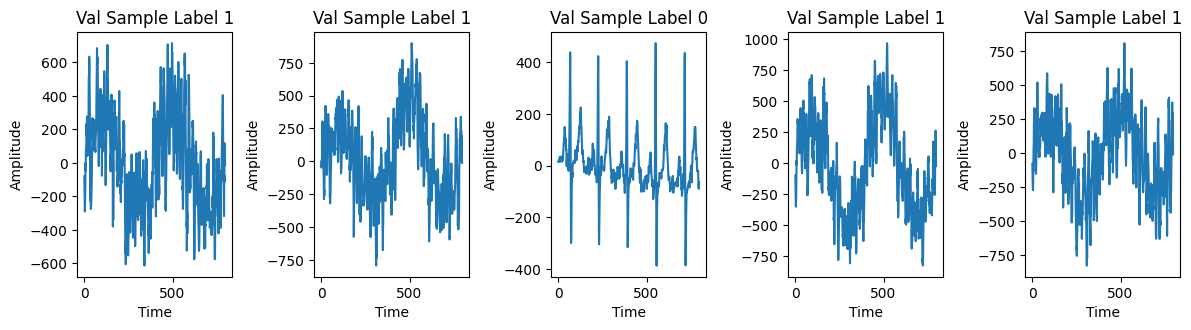

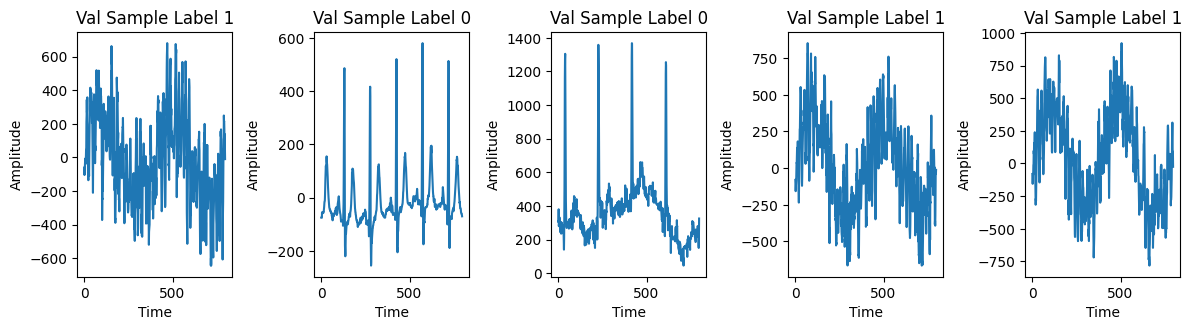

In [14]:
import matplotlib.pyplot as plt

#train dataset visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    sample, label = train_dataset[i]  
    sample = sample.squeeze(0)  
    sample = sample.cpu().numpy()  
    plt.subplot(2, 5, i + 1)  
    plt.plot(sample) 
    plt.title(f"Train Sample Label {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

#val dataset visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    sample, label = val_dataset[i] 
    sample = sample.squeeze(0)  
    sample = sample.cpu().numpy()  
    plt.subplot(2, 5, i + 1)  
    plt.plot(sample) 
    plt.title(f"Val Sample Label {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



In [15]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten_size = 64 * (799 // (2 * 2 * 2))  # size after 3 pooling layers

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 1)  #output 1 value for binary classification (logit)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = torch.relu(self.conv3(x))
        x = self.pool3(x)

        #flatten the tensor to feed into fully connected layers
        x = x.view(x.shape[0], -1)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  

        return x  # raw logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN().to(device)
summary(model, input_size=(1, 799)) 



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 799]              96
         MaxPool1d-2              [-1, 16, 399]               0
            Conv1d-3              [-1, 32, 399]           2,592
         MaxPool1d-4              [-1, 32, 199]               0
            Conv1d-5              [-1, 64, 199]          10,304
         MaxPool1d-6               [-1, 64, 99]               0
            Linear-7                  [-1, 128]         811,136
            Linear-8                    [-1, 1]             129
Total params: 824,257
Trainable params: 824,257
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 3.14
Estimated Total Size (MB): 3.59
----------------------------------------------------------------


In [16]:
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad() 
        
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels.float())  
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")



Epoch [1/10], Loss: 7.675212740299425
Epoch [2/10], Loss: 8.856726346639084e-05
Epoch [3/10], Loss: 4.7118593932807925e-22
Epoch [4/10], Loss: 1.5787876184644253e-22
Epoch [5/10], Loss: 1.379721067297684e-22
Epoch [6/10], Loss: 1.3754548947486033e-22
Epoch [7/10], Loss: 1.3751531008268317e-22
Epoch [8/10], Loss: 1.3751523317792743e-22
Epoch [9/10], Loss: 1.3751523317798938e-22
Epoch [10/10], Loss: 1.542215653456917e-22


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, data_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []
    all_probs = []  

    with torch.no_grad():  #no gradients needed for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  

            #get probabilities using sigmoid
            probabilities = torch.sigmoid(outputs)

            preds = (probabilities >= 0.5).cpu().numpy().astype(int)  # label 1 if probabilities >= 0.5

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  
            all_probs.extend(probabilities.cpu().numpy()) 

    cm = confusion_matrix(all_labels, all_preds)
    
    report = classification_report(all_labels, all_preds, target_names=["NSR", "VFib"])

    return cm, report, all_probs, all_labels, all_preds

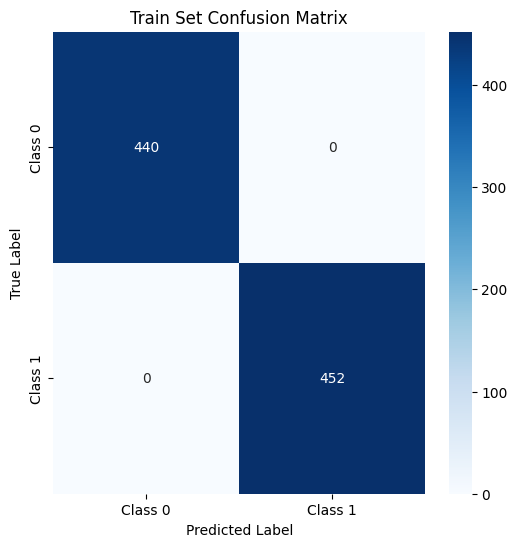

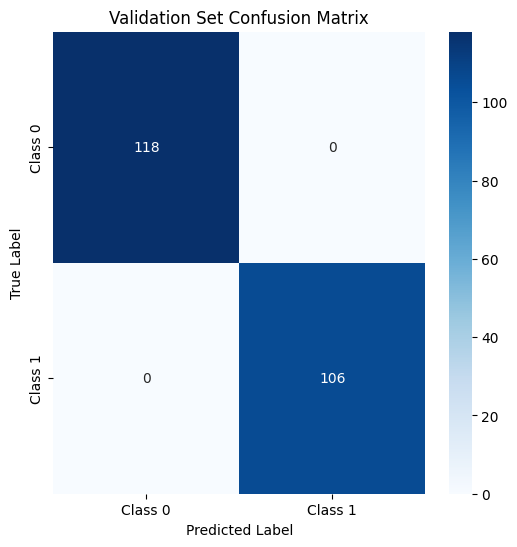

Train Classification Report:
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00       440
        VFib       1.00      1.00      1.00       452

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892


Validation Classification Report:
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00       118
        VFib       1.00      1.00      1.00       106

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



In [18]:
import seaborn as sns

train_cm, train_report, train_probs, train_labels, train_preds = evaluate_model(model, train_loader, device)
val_cm, val_report, val_probs, val_labels, val_preds = evaluate_model(model, val_loader, device)

#display confusion matrix using seaborn heatmap
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(train_cm, title="Train Set Confusion Matrix")
plot_confusion_matrix(val_cm, title="Validation Set Confusion Matrix")

print("Train Classification Report:")
print(train_report)

print("\nValidation Classification Report:")
print(val_report)


In [19]:
print("Train Sample Labels and Probabilities:")
for label, prob in zip(train_labels[:10], train_probs[:10]):
    print(f"Label: {label}, Probability: {prob}")

print("\nVal Sample Labels and Probabilities:")
for label, prob in zip(val_labels[:10], val_probs[:10]):
    print(f"Label: {label}, Probability: {prob}")

Train Sample Labels and Probabilities:
Label: 0, Probability: 0.0
Label: 0, Probability: 0.0
Label: 0, Probability: 0.0
Label: 0, Probability: 0.0
Label: 0, Probability: 0.0
Label: 0, Probability: 4.6752904661252566e-27
Label: 1, Probability: 1.0
Label: 0, Probability: 0.0
Label: 0, Probability: 3.426107222508163e-33
Label: 0, Probability: 1.1386216697206094e-29

Val Sample Labels and Probabilities:
Label: 1, Probability: 1.0
Label: 0, Probability: 0.0
Label: 0, Probability: 0.0
Label: 1, Probability: 1.0
Label: 1, Probability: 1.0
Label: 1, Probability: 1.0
Label: 0, Probability: 5.940852528716814e-30
Label: 1, Probability: 1.0
Label: 0, Probability: 0.0
Label: 1, Probability: 1.0


In [20]:
base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "ptbxl_database.csv")  

df = pd.read_csv(metadata_path)

test_ecg_segments = []

threshold = 5

for idx, row in df.iterrows():
    scp_codes = eval(row["scp_codes"])  

    if "AFLT" not in scp_codes or abs(scp_codes["AFLT"] - 100) > threshold:
        continue
    hr_path = os.path.join(base_path, row["filename_hr"])  

    record = wfdb.rdrecord(hr_path)

    ecg_signal = record.p_signal[:, 0]

    segment_size = 2000
    num_segments = len(ecg_signal) // segment_size  

    for i in range(num_segments):
        segment = ecg_signal[i * segment_size : (i + 1) * segment_size]
        test_ecg_segments.append(segment)

    if len(test_ecg_segments) >= 5:
        break

test_ecg_segments = np.array(test_ecg_segments)
test_ecg_segments = test_ecg_segments * 1000

lr_test_ecg_segments = []
for test_ecg_segment in test_ecg_segments:
    lr_test_ecg_segment = []
    for i in range(len(test_ecg_segment)):
        if (i % 5 == 0):
            lr_test_ecg_segment.append(test_ecg_segment[i])
        elif (i % 5 == 2):
            lr_test_ecg_segment.append((test_ecg_segment[i] + test_ecg_segment[i + 1])/2)
    lr_test_ecg_segments.append(lr_test_ecg_segment)

lr_test_ecg_segments = np.array(lr_test_ecg_segments)
lr_test_ecg_segments

array([[-60. , -60.5, -60. , ...,  37. ,  20. ,   1. ],
       [-10. , -36. , -30. , ..., -43. ,  40. , 132.5],
       [-50. , -50. , -50. , ...,  49. ,  45. ,  44.5],
       [ 45. ,  35. ,  30. , ..., -14. , -15. ,  -9. ],
       [-70. , -70. , -70. , ..., -44. , -70. , -38. ],
       [-30. , -15. ,   5. , ..., 612.5, 885. , 880. ]])

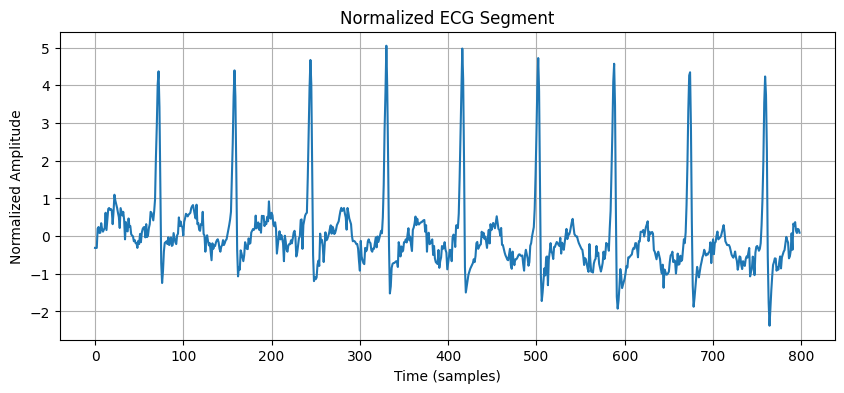

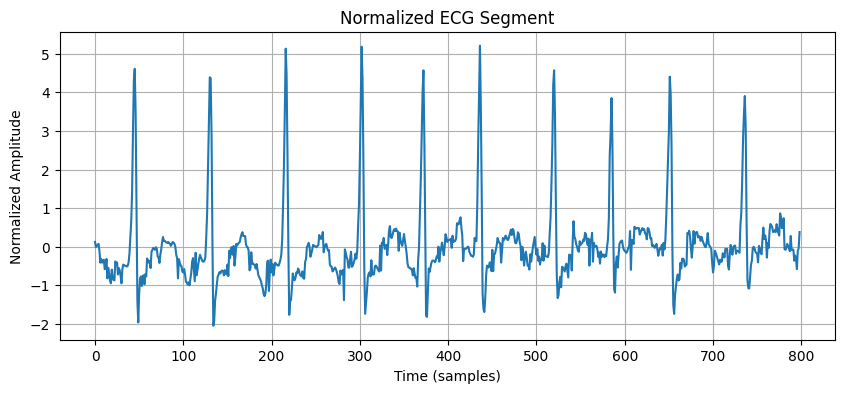

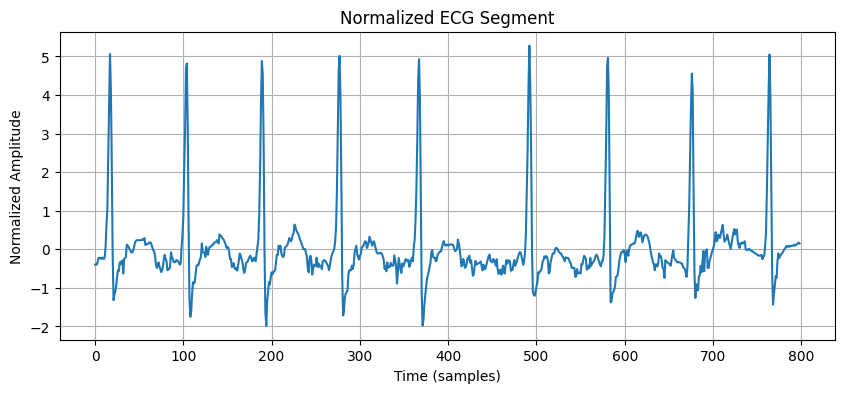

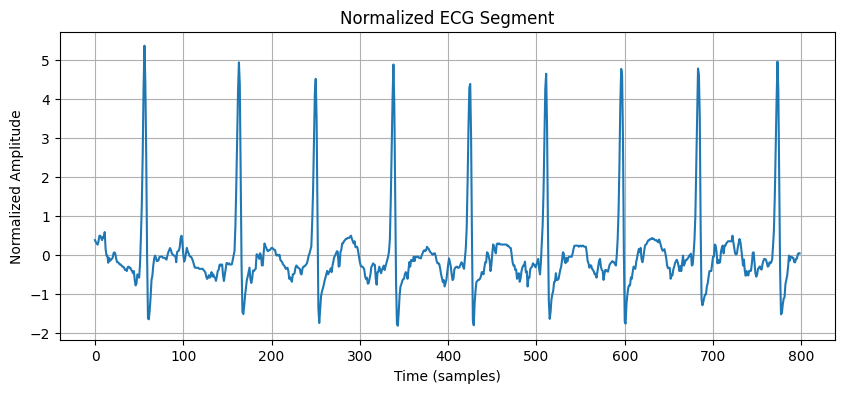

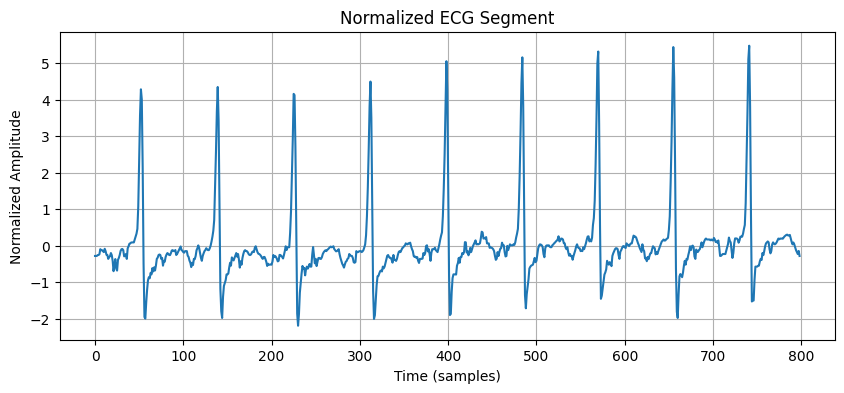

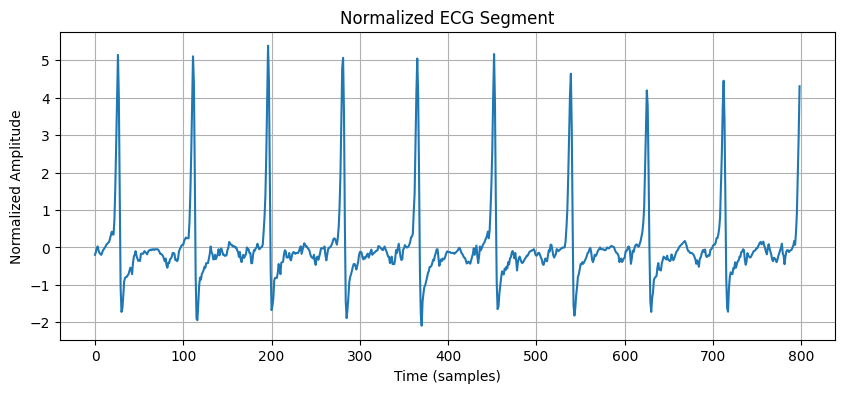

In [30]:
for ecg_segment in lr_test_ecg_segments:
    ecg_segment = ecg_segment[:799]

    ecg_segment = (ecg_segment - np.mean(ecg_segment)) / np.std(ecg_segment)

    plt.figure(figsize=(10, 4))
    plt.plot(ecg_segment)
    plt.title("Normalized ECG Segment")
    plt.xlabel("Time (samples)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.show()

In [21]:
model.eval()  

test_probs = []
test_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad(): 
    for ecg_segment in lr_test_ecg_segments:
        ecg_segment = ecg_segment[:799]
        #ecg_segment = (ecg_segment - np.mean(ecg_segment)) / np.std(ecg_segment) 

        ecg_segment_tensor = torch.tensor(ecg_segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        logits = model(ecg_segment_tensor)

        print(f"Logits: {logits}")

        probabilities = torch.sigmoid(logits).cpu().numpy() 
        print(f"Probabilities: {probabilities}")

        prediction = (probabilities >= 0.5).astype(int)

        test_probs.append(probabilities[0][0])  
        test_preds.append(prediction[0][0])

        print(f"Pred: {prediction[0][0]} with Probability: {probabilities[0][0]}")

Logits: tensor([[-225.1661]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0
Logits: tensor([[-205.3196]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0
Logits: tensor([[-208.9576]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0
Logits: tensor([[-183.5300]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0
Logits: tensor([[-193.9769]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0
Logits: tensor([[-206.7604]], device='cuda:0')
Probabilities: [[0.]]
Pred: 0 with Probability: 0.0


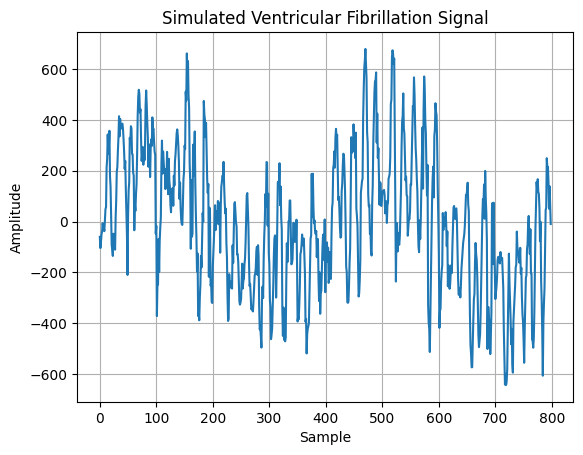

(799,)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 799  # number of samples

zero_signal, zero_label = val_dataset[0]
zero_signal = zero_signal.squeeze(0)  
zero_signal = zero_signal.cpu().numpy()

# Create an array of indices for the x-axis (samples)
x_values = np.arange(len(zero_signal))

# Plot the signal
plt.plot(x_values, zero_signal)
plt.title("Simulated Ventricular Fibrillation Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Output the signal for further processing
zero_signal.shape



In [31]:
ecg_segment_tensor = torch.tensor(zero_signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad(): 
    logits = model(ecg_segment_tensor)
    print(logits)
    probabilities = torch.sigmoid(logits).cpu().numpy() 
    print(f"Probabilities: {probabilities}")
    prediction = (probabilities >= 0.5).astype(int)
    print(f"Pred: {prediction[0][0]} with Probability: {probabilities[0][0]}")

tensor([[82.6943]], device='cuda:0')
Probabilities: [[1.]]
Pred: 1 with Probability: 1.0
